<a href="https://colab.research.google.com/github/matthewhasman/Virtual-AM-Radio/blob/main/Virtual_AM_Radio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Virtual AM Radio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, Image
from IPython.core.display import HTML

This is a simulated AM radio which realistically conducts the operation of the receiver and demodulation process of a radio. The radio is capable of broadcasting music stations spaced 20kHz apart. 

5 songs are uploaded as an example. A sampling rate of ~40000 samples/second is required to satisfy the Nyquist theorem, as music often occupies approximately 20kHz of spectrum. 

In [ ]:
input_audio1 = wavfile.read("clip1.wav")
sample_rate1 = input_audio1[0]
channel0_1 = input_audio1[1][:, 0]
input_audio2 = wavfile.read("clip2.wav")
sample_rate2 = input_audio2[0]
channel0_2 = input_audio2[1][:, 0]
input_audio3 = wavfile.read("clip3.wav")
sample_rate3 = input_audio3[0]
channel0_3 = input_audio3[1][:, 0]
input_audio4 = wavfile.read("clip4.wav")
sample_rate4 = input_audio4[0]
channel0_4 = input_audio4[1][:, 0]
input_audio5 = wavfile.read("clip5.wav")
sample_rate5 = input_audio5[0]
channel0_5 = input_audio5[1][:, 0]

Text(0.5, 0, 'Frequency (Hz)')

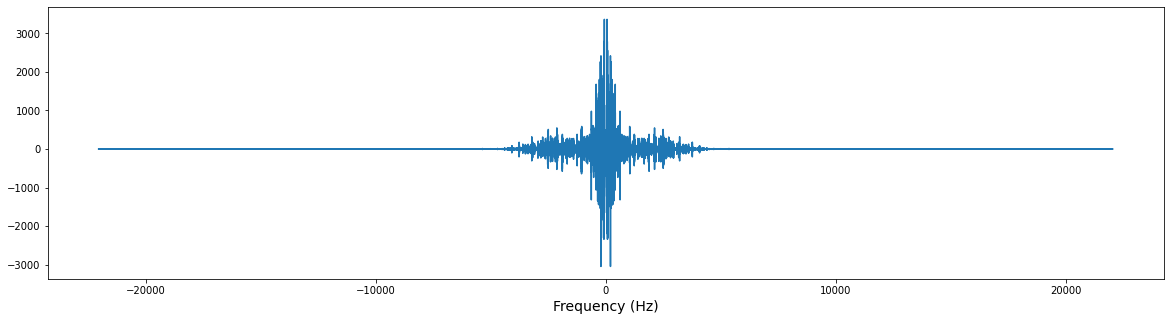

In [ ]:
song_1 = np.array(channel0_1, dtype=np.float64)[:221807] / np.max(channel0_1)
song_2 = np.array(channel0_2, dtype=np.float64)[:221807] / np.max(channel0_2)
song_3 = np.array(channel0_3, dtype=np.float64)[:221807] / np.max(channel0_3)
song_4 = np.array(channel0_4, dtype=np.float64)[:221807] / np.max(channel0_4)
song_5 = np.array(channel0_5, dtype=np.float64)[:221807] / np.max(channel0_5)

frequencies = np.fft.fftfreq(len(song_4), 1/sample_rate1)
spectrum = np.fft.fft(song_4)

plt.figure(figsize=(20, 5))
plt.plot(frequencies, spectrum.real)
plt.xlabel("Frequency (Hz)", fontsize=14)

## Part 1. The broadcast

First, a lowpass filter is designed to reduce the bandwidth of a signal to within the acceptable range of our radio stations.

In [ ]:
def reduce_signal_bandwidth(signal, sample_rate, max_freq=10000):
    """Reduce the bandwidth of a signal to within a ~20 kHz band.
    
    Args:
        signal (array[float]): A real-valued signal.
        
    Returns:
        array[float]: A signal that has been filtered so that its spectrum is 
        band-limited. 
    """

    frequencies = np.fft.fftfreq(len(signal), 1/sample_rate)
    spectrum = np.fft.fft(signal)
    max_freq = 10000

    filter = np.zeros(len(spectrum), dtype=np.complex128)

    for i in range(len(spectrum)):
      if np.abs(frequencies[i]) <= max_freq:
        filter[i] = spectrum[i]

    return np.fft.ifft(filter)

Next a function must perform sinusoidal amplitude modulation of a signal into the frequency range of a desired radio station.

In [ ]:
def sinusoidal_amplitude_modulation(signal, station_frequency, sample_rate, phase=0.0):
    """Modulate a signal up to the frequency of a desired AM radio station.
    
    Args:
        signal (array[float]): A real-valued signal.
        station_frequency (int): The (carrier) frequency of the station, in kHz.
        phase (float): The phase of the carrier signal. 
        
    Returns:
        array[float]: The modulated signal.
    """
    output = np.zeros(len(signal), dtype=np.complex128)
    for i in range(len(output)):
      output[i] = signal[i] * np.cos(2*np.pi*station_frequency*1000*i/sample_rate + phase)

    return output

This radio uses frequency-division multiplexing (FDM) to send multiple signals over the same channel. The following implements a broadcast (transmission) system that takes a set of signals as input, and outputs the full radio broadcast. Upsampling of a factor of 35 is required to compress the frequency spectrum of the signals to fit in their respective broadcasting channels without aliasing. 

In [ ]:
def broadcast(signals, sample_rate):
    """Broadcast a set of signals at different frequencies to simulate 
    a set of radio stations.
    
    Args:
        signals (list[array[float]]): A list of signals to be transmitted. 
             Assume that they are provided in order of increasing station frequency.
    
    Returns:
        array[float]: A single channel contain the frequency-division multiplexed
        set of signals.
    """

    output = np.zeros_like(len(np.repeat(signals[0], 35)), dtype=np.complex128)
    freqs = [580, 600, 620, 640, 660]
    for i in range(len(signals)):
        reduced_band = np.repeat(signals[i], 35)
        output = output + sinusoidal_amplitude_modulation(reduced_band, freqs[i], sample_rate*35, phase=0.0)

    return output

## Part 2. A  Receiver

In order to test the broadcasting setup, I have implemented a synchronous demodulation system.

In [ ]:
def simple_receiver(broadcast, station_frequency, sample_rate, phase=0.0, bandpass=True):
    """Demodulate the radio broadcast and extract a desired station.
    
    
    Args:
        broadcast (array[float]): A radio broadcast consisting of five channels
            that have been FD multiplexed.
        station_frequency (int): The frequency (in kHz) of the radio station.
        phase (float): The phase of the demodulating signal.
        bandpass (bool): Whether or not to apply a bandpass filter before
            demodulating and filtering.
    
    Returns:
        array[float]: The signal of the radio station at the desired frequency.
    """

    frequencies = np.fft.fftfreq(len(broadcast), 1/(sample_rate*35))
    spectrum = np.fft.fft(broadcast)
    max_freq = 10000

    if bandpass:
      bandPass = np.zeros(len(spectrum), dtype=np.complex128)
      for i in range(len(spectrum)):
        if np.abs(frequencies[i]) <= max_freq + station_frequency*1000 and np.abs(frequencies[i]) >= station_frequency*1000 - max_freq:
          bandPass[i] = spectrum[i]

    else:
      bandPass = spectrum

    song = np.fft.ifft(bandPass)

    frequencies2 = np.fft.fftfreq(len(song), 1/(sample_rate1*35))
    spectrum2 = np.fft.fft(song)

    shifted = np.zeros(len(song), dtype=np.complex128)
    for i in range(len(song)):
        shifted[i] = (song[i] * np.cos(2*np.pi*station_frequency*1000*i/(sample_rate*35) + phase))

    # Undo the upsampling that was conducted during the broadcasting process
    decimated = np.zeros(int(np.floor(len(shifted)/35)))
    for i in range(len(shifted)):
      j = int(i/35)
      if i % 35 == 0:
        decimated[j] = shifted[i]

    frequencies3 = np.fft.fftfreq(len(decimated), 1/(sample_rate1))
    spectrum3 = np.fft.fft(decimated)
    max_freq = 8000

    filter = np.zeros(len(spectrum3), dtype=np.complex128)

    for i in range(len(frequencies3)):
      if np.abs(frequencies3[i]) <= max_freq:
        filter[i] = spectrum3[i]

    frequencies4 = np.fft.fftfreq(len(filter), 1/(sample_rate1))
    spectrum4 = filter

    return np.fft.ifft(filter)

Testing the demodulation function below to extract the 600 kHz station.

In [ ]:
signals = [song_1, song_2, song_3, song_4, song_5]

song1 = reduce_signal_bandwidth(song_1, sample_rate1)
song2 = reduce_signal_bandwidth(song_2, sample_rate1)
song3 = reduce_signal_bandwidth(song_3, sample_rate1)
song4 = reduce_signal_bandwidth(song_4, sample_rate1)
song5 = reduce_signal_bandwidth(song_5, sample_rate1)

input = [song1, song2, song3, song4, song5]
broadcast1 = broadcast(input, sample_rate1)

frequencies2 = np.fft.fftfreq(len(broadcast1), 1/(sample_rate1*35))
spectrum2 = np.fft.fft(broadcast1)